# Set up

## Import

In [1]:
#import
import numpy as np
import pandas as pd

import os
import glob
from rastertodataframe import raster_to_dataframe

from math import floor

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
#custom functions

#function to create histogram of scenes class frequency
def nrcan_hist(img):
    import numpy as np
    import pandas as pd
    from collections import Counter

    im_array = np.array(img)

    #last line is bad values 
    im_array = im_array[:-1]

    #value count
    freq = Counter(im_array.flatten())

    plt.bar(freq.keys(), freq.values())
    plt.xlim([-1, 20])
    
#function to turn tiff to df
def tiff_to_df_colab(path):

    #Create folder path and list variables
    folder_path = path
    file_list = glob.glob(folder_path + "/*.tiff")

    #initiate empty dataframe
    main_dataframe = pd.DataFrame()

    for i in file_list:
        data = raster_to_dataframe(i)
  
        #extract name of band from file path
        band_info = str(i).split('/')[-1]
        band_name = band_info[-14:-11]
        #rename with band name
        data = data.rename(columns = {'Band_1': band_name})
        #merge into main dataframe
        main_dataframe = pd.concat([main_dataframe, data], axis = 1)

    return main_dataframe

## NRCan labels

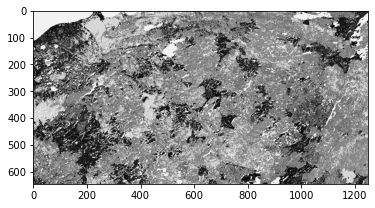

In [3]:
#import selected nrCAN extents
sask_nrcan = Image.open('../data_tests/scene_4/NRCAN_transformed.tif')
#show image
plt.imshow(sask_nrcan, cmap = 'gray', vmin = 0, vmax = 19)

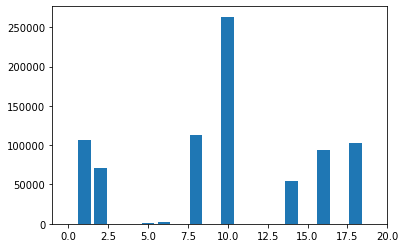

In [4]:
#class histogram plot
nrcan_hist(sask_nrcan)

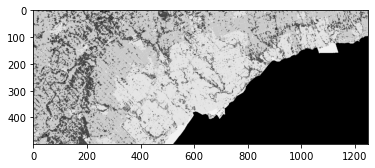

In [5]:
tor_nrcan = Image.open('../data_tests/scene_5/NRCAN_transformed.tif')
#show image
plt.imshow(tor_nrcan, cmap = 'gray', vmin = 0, vmax = 19)

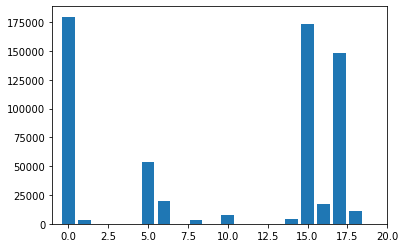

In [6]:
#class histogram plot
nrcan_hist(tor_nrcan)

## Raw bands

In [7]:
#load in raw bands
sask_raws = tiff_to_df_colab('../data_tests/scene_4/raws')
tor_raws = tiff_to_df_colab('../data_tests/scene_5/raws')
sim_raws = tiff_to_df_colab('../data_tests/simcoe_york/raws')
lab_raws = tiff_to_df_colab('../data_tests/labrador/raws')

sim_nrcan = raster_to_dataframe('../data_tests/simcoe_york/Simcoe_York_2019.tif')
lab_nrcan = raster_to_dataframe('../data_tests/labrador/NRCAN_transformed.tif')

sask_raws.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0481,0.0393,0.0398,0.0185,0.0172,0.0133,0.0136,0.0129,0.0179,0.0075,0.0068,0.0120
3,0.0462,0.0355,0.0382,0.0178,0.0157,0.0123,0.0120,0.0123,0.0157,0.0072,0.0059,0.0108
4,0.0421,0.0356,0.0381,0.0180,0.0160,0.0124,0.0118,0.0135,0.0162,0.0072,0.0066,0.0112


In [8]:
lab_raws.shape, lab_nrcan.shape

((2082500, 12), (2082500, 1))

In [9]:
#convert nrcan extents to 1 dimension array
sask_labels = np.asarray(sask_nrcan).reshape(len(sask_raws))
tor_labels = np.asarray(tor_nrcan).reshape(len(tor_raws))


#add label column
sask_raws['y'] = sask_labels
tor_raws['y'] = tor_labels
sim_raws['y'] = sim_nrcan
lab_raws['y'] = lab_nrcan

tor_raws.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,y
0,0.0934,0.1228,0.1588,0.2052,0.2344,0.2549,0.2729,0.2928,0.2947,0.3868,0.3853,0.2917,15
1,0.0890,0.1163,0.1507,0.1944,0.2210,0.2390,0.2560,0.2761,0.2777,0.3842,0.3827,0.2757,15
2,0.0893,0.1157,0.1511,0.1944,0.2199,0.2363,0.2552,0.2752,0.2764,0.3886,0.3842,0.2765,15
3,0.1104,0.1609,0.1919,0.2144,0.2526,0.2926,0.3128,0.3342,0.3254,0.3672,0.3320,0.3325,15
4,0.0723,0.0913,0.1220,0.1250,0.1730,0.2769,0.3134,0.3368,0.3366,0.3020,0.2353,0.3376,15


# EDA

In [10]:
from itertools import product

In [11]:
#in nrcan Nulls translate as 0
print((sask_raws.loc[sask_raws['y'] == 0]).empty) #none in sask extent
print((tor_raws.loc[tor_raws['y'] == 0]).empty) #there are in tor
print((lab_raws.loc[lab_raws['y'] == 0]).empty)

#in this case they all correspond to water
tor_raws['y'] = tor_raws['y'].replace({0:18})
lab_raws['y'] = lab_raws['y'].replace({0:18})
print((tor_raws.loc[tor_raws['y'] == 0]).empty) #all converted to water
print((lab_raws.loc[lab_raws['y'] == 0]).empty)


True
False
False
True
True


In [12]:
sim_classes = sim_raws.value_counts('y')
print(sim_classes)

y 
15    2836714
18     685749
5      607429
17     512418
6      375582
14      92096
1       79933
16      70525
8       55794
10      18760
dtype: int64


In [13]:
lab_classes = lab_raws.value_counts('y')
print(lab_classes)

y 
13    618139
12    526286
16    375422
18    268056
11    165380
19     47120
1      35009
2      20946
8      15404
5       5931
6       3296
14      1500
10        11
dtype: int64


In [14]:
#vertical concat
main_dataframe = pd.concat([sim_raws, lab_raws])
#main_dataframe = lab_raws

print(main_dataframe.shape)
main_classes = main_dataframe.value_counts('y').sort_index() 
print(main_classes)

(7417500, 13)
y 
1      114942
2       20946
5      613360
6      378878
8       71198
10      18771
11     165380
12     526286
13     618139
14      93596
15    2836714
16     445947
17     512418
18     953805
19      47120
dtype: int64


In [15]:
#select classes above threshold
threshold = 5000
main_top_classes = main_classes[main_classes > threshold].reset_index().y

#save dataframe subset of those classes
main_subset = main_dataframe.loc[main_dataframe['y'].isin(main_top_classes.values)]

#take smallest value rounded down to nearest 1000
smallest_class = int(floor(min(main_subset.value_counts('y').sort_index().values)/ 1000)) * 1000
#subsampling - comment out for full set
smallest_class = threshold

#take subset of each class equal to smallest class value
data = main_subset.groupby("y").sample(n=smallest_class, random_state=24)
print(data.shape)
data.value_counts('y').sort_index()

(75000, 13)


y 
1     5000
2     5000
5     5000
6     5000
8     5000
10    5000
11    5000
12    5000
13    5000
14    5000
15    5000
16    5000
17    5000
18    5000
19    5000
dtype: int64

# Modelling

Random Forest, SVC, XGBoost [stretch] CNN

Iteration details:
- toronto, simcoe, sask = standard bands, no parameters, 5K each value, no scaling, in turn toronto, simcoe, and sask extents only
[currently the rest are based on tor + sask, sask is no good and tor overlaps with sim]
- Base run = standard bands, no parameters, 5K each value, no scaling, sim and lab
- scaled = standard bands, no params, 5K each value, StandardScaler() -> improved SVC, sask and tor
- large set = standard bands, no parameters, 18K each value, no scaling, sim and lab

Parameterization note: so far best results for RFC come from default with n_estimators = 300 with accuracy around 58.74

To do:
- ensure all raws are aligned to a common 60 m res grid (downsampling all but b1 and b9)
- scaling sim & lab for svc -> if goes well svc parametrization
- basic NN?

## Import

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets

In [17]:
#set up save path for images
confusion_path = 'confusion_matrices/'
group_folder = 'base_run/'

## Processing

In [18]:
#add bands
#Create NDVI column (B8-B4)/(B8+B4)
#data['NDVI'] = (data.B08-data.B04)/(data.B08+data.B04)
#Create Moisture index (B8A-B11)/(B8A+B11)
#data['Moisture'] = (data.B8A-data.B11)/(data.B8A+data.B11)
#Create NDWI (B3-B8)/(B3+B8)
#data['NDWI'] = (data.B03-data.B08)/(data.B03+data.B08)
#create NDSI (B3-B11)/(B3+B11)
#data['NDSI'] = (data.B03-data.B11)/(data.B03+data.B11)


#Ensure that all values are float32
#np.where(data.values >= np.finfo(np.float32).max)

In [19]:
y = data.y
X = data.drop('y', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8, random_state = 0)

In [20]:
y_train.value_counts()

12    4000
14    4000
16    4000
8     4000
11    4000
10    4000
6     4000
18    4000
13    4000
5     4000
15    4000
1     4000
2     4000
19    4000
17    4000
Name: y, dtype: int64

In [21]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

### SVC

In [22]:
#Different SVC kernels - sig performed less then 1 percent on subsample so its removed
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
#sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [23]:
#predict from X_test
linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
#sig_pred = sig.predict(X_test)

0.43846666666666667
0.4914
0.47226666666666667


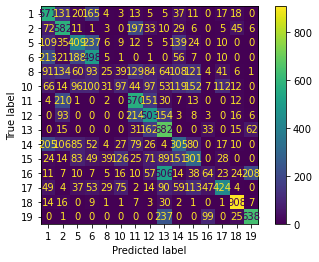

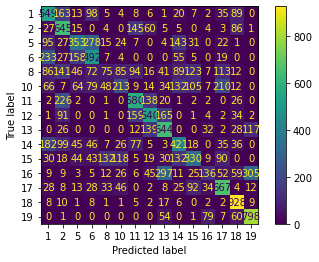

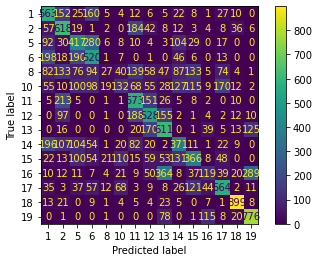

In [24]:
# retrieve the accuracy and print it for all 4 kernel functions
accuracy_lin = linear.score(X_test, y_test)
accuracy_poly = poly.score(X_test, y_test)
accuracy_rbf = rbf.score(X_test, y_test)
#accuracy_sig = sig.score(X_test, y_test)

# creating a confusion matrix
cm_lin = confusion_matrix(y_test, linear_pred)
cm_poly = confusion_matrix(y_test, poly_pred)
cm_rbf = confusion_matrix(y_test, rbf_pred)
#cm_sig = confusion_matrix(y_test, sig_pred)

#visual confusion matrix
cm_lin_fig = ConfusionMatrixDisplay(confusion_matrix = cm_lin, display_labels = linear.classes_)
cm_poly_fig = ConfusionMatrixDisplay(confusion_matrix = cm_poly, display_labels = poly.classes_)
cm_rbf_fig = ConfusionMatrixDisplay(confusion_matrix = cm_rbf, display_labels = rbf.classes_)

#print accuracy and confusion matrix
print(accuracy_lin)
cm_lin_fig.plot()
print(accuracy_poly)
cm_poly_fig.plot()
print(accuracy_rbf)
cm_rbf_fig.plot()

In [25]:
#save confusion matrices
cm_lin_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'lin.png'), dpi = 300)
cm_poly_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'poly.png'), dpi = 300)
cm_rbf_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'rbf.png'), dpi = 300)

### Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

0.5588


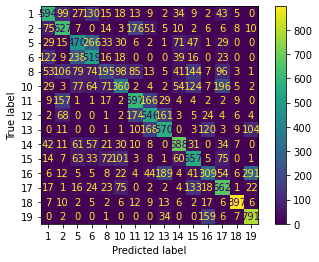

In [27]:
forest = RandomForestClassifier(random_state = 0).fit(X_train, y_train)

#get accuracy
accuracy_forest = forest.score(X_test, y_test)
print(accuracy_forest)

#plot confusion matrix
forest_pred = forest.predict(X_test)
cm_forest = confusion_matrix(y_test, forest_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
cm_forest_fig.plot()

In [28]:
#band weight
forest.feature_importances_

array([0.11108713, 0.09149395, 0.08385644, 0.07850562, 0.06802462,
       0.0751895 , 0.07287168, 0.07097423, 0.08034746, 0.0926677 ,
       0.0973828 , 0.07759885])

In [29]:
#save
cm_forest_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'forest.png'))
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           1       0.59      0.59      0.59      1000
           2       0.55      0.63      0.59      1000
           5       0.45      0.47      0.46      1000
           6       0.44      0.52      0.48      1000
           8       0.40      0.20      0.26      1000
          10       0.47      0.36      0.41      1000
          11       0.55      0.60      0.57      1000
          12       0.53      0.55      0.54      1000
          13       0.56      0.57      0.57      1000
          14       0.68      0.69      0.68      1000
          15       0.50      0.56      0.53      1000
          16       0.46      0.31      0.37      1000
          17       0.53      0.66      0.59      1000
          18       0.93      0.90      0.91      1000
          19       0.64      0.79      0.71      1000

    accuracy                           0.56     15000
   macro avg       0.55      0.56      0.55     15000
weighted avg       0.55   

### XGBoost

In [30]:
import xgboost as xgb

In [31]:
xg_classes = list(range(len(y_train.unique())))

xg_y_train = y_train.replace(y_train.unique(), xg_classes)
xg_y_test = y_test.replace(y_test.unique(), xg_classes)

0.0414


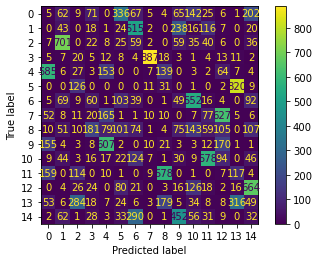

In [32]:
xg_cl = xgb.XGBClassifier().fit(X_train, xg_y_train)

#get accuracy
accuracy_xgb = xg_cl.score(X_test, xg_y_test)
print(accuracy_xgb)

#plot confusion matrix
xgb_pred = xg_cl.predict(X_test)
cm_xgb = confusion_matrix(xg_y_test, xgb_pred)
cm_xgb_fig = ConfusionMatrixDisplay(cm_xgb)
cm_xgb_fig.plot()

In [33]:
#save
cm_xgb_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'xgb.png'), dpi = 300)